In [73]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import os
from box import Box
import random

import torch
import torchvision
from torchvision import transforms
import torchvision.transforms.functional as F
from torch.utils.data import Dataset, DataLoader


In [74]:
os.environ["CUDA_VISIBLE_DEVICES"]='6'

In [75]:
config = {
    'input':{
        'image_dir':'./input/kaggle_dogs'
    },
    'plot':'./plot',
    'seed':0,
    "transforms":{
        "size":(512, 512),
        "mean":(0.485, 0.456, 0.406),
        "std":(0.229, 0.224, 0.225),
    },
    'hparams':{
        'batch_size':8,
    },
}

config = Box(config)

In [76]:
def seed_torch(seed:int):
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(config.seed)

In [77]:
dogs_fname_list = os.listdir(config.input.image_dir)
print(f"{len(dogs_fname_list)} files")

dogs_df = pd.DataFrame(columns=['id', 'filename', 'sim'])
dogs_df['filename'] = dogs_fname_list
dogs_df['id'] = dogs_df.filename.map(lambda x: int(x[4:-4]))
dogs_df['sim'] = 0
dogs_df.sort_values('id', inplace=True)
dogs_df.reset_index(inplace=True, drop=True)
display(dogs_df)

12500 files


,id,filename,sim
0,0,dog.0.jpg,0
1,1,dog.1.jpg,0
2,2,dog.2.jpg,0
3,3,dog.3.jpg,0
4,4,dog.4.jpg,0
...,...,...,...
12495,12495,dog.12495.jpg,0
12496,12496,dog.12496.jpg,0
12497,12497,dog.12497.jpg,0
12498,12498,dog.12498.jpg,0


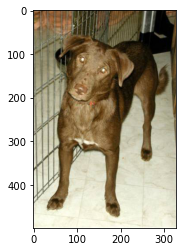

In [78]:
img_path = os.path.join(config.input.image_dir, dogs_df.loc[1, 'filename'])
img = Image.open(img_path)
plt.imshow(img)

In [79]:
class ImageTransform():
    """
    Class for image preprocessing.
    
    Attributes
    ----------
    resize : int
        224
    mean : (R, G, B)
        Average value for each color channel
    std : (R, G, B)
        Standard deviation for each color channel
    """
    
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                #transforms.Resize(resize),
                #transforms.CenterCrop(resize),
                transforms.RandomResizedCrop(
                    resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                #transforms.ColorJitter(),  # Randomly change brightness, contrast, saturation, and hue. 
                #transforms.RandomAffine(degrees=[-10, 10]),  # random affine transformations.
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            'val': transforms.Compose([
                transforms.Resize(resize),
                #transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            'test': transforms.Compose([
                transforms.Resize(resize),
                #transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            'sub': transforms.Compose([
                transforms.Resize(resize),
                #transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }
    
    def __call__(self, img, phase="train"):
        """
        Parameters
        ----------
        phase: 'train' or 'val' or 'test'
            Specify the mode of preprocessing
        """
        return self.data_transform[phase](img)

torch.Size([3, 512, 512])
tensor(2.5703) tensor(-2.1179) tensor(0.3302)


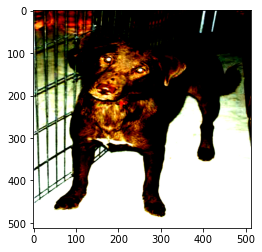

In [80]:
transform = ImageTransform(config.transforms.size, config.transforms.mean, config.transforms.std)
img_transformed_o = transform(img, phase='test')
print(img_transformed_o.shape)

print(img_transformed_o.max(), img_transformed_o.min(), img_transformed_o.mean())
img_transformed = img_transformed_o.numpy().transpose([1, 2, 0])
img_transformed = np.clip(img_transformed, 0, 1)
plt.imshow(img_transformed)

In [81]:
class CustomDataset(Dataset):
    def __init__(self, df, config:dict, transform, phase='test'):
        self.df = df
        self.config = config
        self.transform = transform
        self.phase = phase
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        # Image
        img_path = os.path.join(config.input.image_dir, self.df.loc[idx, 'filename'])
        img = Image.open(img_path)
        img = self.transform(img, self.phase)

        # label
        label = torch.tensor(-1)

        # filename
        filename = self.df.loc[idx, 'filename']
        
        return img, label, filename

In [82]:
ds = CustomDataset(df=dogs_df, config=config, transform=transform, phase='test')
img, label, filename = ds[0]
print(f"{filename} Image:{img.shape}, Label:{label}")

dog.0.jpg Image:torch.Size([3, 512, 512]), Label:-1


In [83]:
dl = DataLoader(ds, batch_size=config.hparams.batch_size, shuffle=False)
images, labels, filenames = next(iter(dl))
print(f"{filenames} Image:{images.shape}, Label:{labels.shape}")

('dog.0.jpg', 'dog.1.jpg', 'dog.2.jpg', 'dog.3.jpg', 'dog.4.jpg', 'dog.5.jpg', 'dog.6.jpg', 'dog.7.jpg') Image:torch.Size([8, 3, 512, 512]), Label:torch.Size([8])


In [84]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = 'cpu'

model = torchvision.models.segmentation.fcn_resnet50(pretrained=True)
model = model.to(device)
model.eval()

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [85]:
with torch.no_grad():
    images = images.to(device)
    output = model(images)['out']

In [86]:
output.shape

torch.Size([8, 21, 512, 512])

In [87]:
sem_classes = [
    '__background__', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]
sem_class_to_idx = {cls: idx for (idx, cls) in enumerate(sem_classes)}

normalized_masks = torch.nn.functional.softmax(output, dim=1)

class_dim = 1
boolean_dog_masks = (normalized_masks.argmax(class_dim) == sem_class_to_idx['dog'])
print(f"shape = {boolean_dog_masks.shape}, dtype = {boolean_dog_masks.dtype}")

shape = torch.Size([8, 512, 512]), dtype = torch.bool


In [88]:
def show(imgs):
    plt.figure(figsize=(30, 10))
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

<Figure size 2160x720 with 0 Axes>

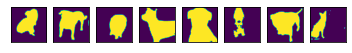

In [89]:
show([m.float() for m in boolean_dog_masks])

In [90]:
masks_np = boolean_dog_masks.float().to('cpu').detach().numpy().copy()

m3_list = [
    np.array([masks_np[i], masks_np[i], masks_np[i]]) \
    for i in range(masks_np.shape[0])
]

m3_np = np.array(m3_list)

print(m3_np.shape)

(8, 3, 512, 512)


In [91]:
images_np = images.float().to('cpu').detach().numpy().copy()
print(images_np.shape)

(8, 3, 512, 512)


In [92]:
cut_images_np = images_np * m3_np
print(cut_images_np.shape)

(8, 3, 512, 512)


In [110]:
t = torch.from_numpy(cut_images_np.astype(np.float32)).clone()
print(t.shape)

torch.Size([8, 3, 512, 512])
